## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Task 1: XNOR

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import numpy as np
from numpy.random import shuffle
import time
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2
print(tf.__version__)

2.4.0


##  Part 1: Backpropagation through time (BPTT)

**Question:** Consider a simple RNN network shown in the following figure, where _wx, wh, b1, w, b2_ are the scalar parameters of the network. The loss function is the **mean squared error (MSE)**. Given input _(x1, x2) = (-1, 2)_, ground truth _(g1, g2) = (0, 1), h0 = 0, and (wx, wh, b1, w, b2) = (3, 1, 2, -1, 1)_, **compute _(dwx, dwh, db1, dw, db2)_**, which are the gradients of loss with repect to 5 parameters _(wx, wh, b1, w, b2)_.

![bptt](./img/bptt2.jpg)

<span style="color:red">TODO:</span>

Answer the above question. 

* Show all of your derivations and the computational process.
* Use LATEX to edit the equations (Jupyter notebook can recognize the basic LATEX syntax). Alternatively, you can edit equations in some other environment and then paste the screenshot of the equations here.

<span style="color:red">Solution:</span>

**[
$$h_1 = sigmoid(w_x * x_1 + w_h * h_0 + b_1) = 0.26894142137$$
$$h_2 = sigmoid(w_x * x_2 + w_h * h_1 + b_1) = 0.99974370918$$ \
$$y_1 = sigmoid(w * h_1 + b_2) = 0.67503752737 $$
$$y_2 = sigmoid(w * h_2 + b_2) = 0.5000640727 $$ \
$$dy_1 = \frac{\partial loss}{\partial y_1} = 0.67503752737$$
$$dy_2 = \frac{\partial loss}{\partial y_2} = -0.4999359273$$\
$$\frac{\partial y_1}{\partial w} = y_1 ( 1 - y_1) h_1 = 0.0589954915 $$ 
$$\frac{\partial y_2}{\partial w} = y_2 ( 1 - y_2) h_2 = 0.24993592319 $$ 
$$ d w= dy_2 * \frac{\partial y_2}{\partial w} + dy_1 * \frac{\partial y_1}{\partial w} = -0.08512777681$$\
$$\frac{\partial y_1}{\partial b_2} = y_1 ( 1 - y_1) = 0.21936186401 $$ 
$$\frac{\partial y_2}{\partial b_2} = y_2 ( 1 - y_2) = 0.24999999589 $$  
$$d b_2= dy_2 * \frac{\partial y_2}{\partial b_2} + dy_1 * \frac{\partial y_1}{\partial b_2} = 0.04380743154$$\
$$ dh_2 = y_2 * (1 - y_2) * w * dy_2 = 0.12498397977 $$
$$ dh_1 = y_1 * (1 - y_1) * w * dy_1 + h_2 * (1- h_2) * w_h * dh_2 = -0.14807749028 + 0.00003202403 = -0.14804546625$$\
$$ dw_x = h_1 * (1 - h_1) * x_1 * dh_1 + h_2 * (1 - h_2) * x_2 * dh_2 = 0.0291715534 $$
$$ dw_h = h_1 * (1 - h_1) * h_0 * dh_1 + h_2 * (1 - h_2) * h_1 * dh_2 = 0.00000861259 $$
$$ db_1 = h_1 * (1 - h_1) * dh_1 + h_2 * (1 - h_2) * dh_2 = 0.02913952936$$
]**

In [2]:
# use tensorflow to verify the answer.
with tf.GradientTape() as G:
    w = tf.Variable(-1.0)
    b2 = tf.Variable(1.0)
    wx = tf.Variable(3.0)
    wh = tf.Variable(1.0)
    b1 = tf.Variable(2.0)

    h0 = tf.Variable(0.0)
    x = tf.Variable((-1.0,2.0))
    g = tf.Variable((0.0, 1.0))

    y = []
    h1 = tf.sigmoid(wx*x[0] + wh*h0 + b1)
    y.append(tf.sigmoid(w*h1 + b2))
    h2 = tf.sigmoid(wx*x[1] + wh*h1 + b1)
    y.append(tf.sigmoid(w*h2 + b2))

    loss = 0.5*(tf.square(g[0]-y[0]) + tf.square(g[1]-y[1]))

    dw_t, db2_t, dwx_t, dwh_t, db1_t = G.gradient(loss, [w, b2, wx, wh, b1])
    

print("Verified by tensorflow (TODO compare values with your hand-written calculations):")
print("dw = {:.4f}, db2 = {:.4f}, dwx = {:.4f}, dwh = {:.4f}, db1 = {:.4f}".format(dw_t, db2_t, dwx_t, dwh_t, db1_t))

Verified by tensorflow (TODO compare values with your hand-written calculations):
dw = -0.0851, db2 = 0.0231, dwx = 0.0292, dwh = 0.0000, db1 = -0.0291


## Part 2: Use TensorFlow modules to create XNOR network

In this part, you need to build and train an XNOR network that can learn the XNOR function. It is a very simple implementation of RNN and will give you an idea how RNN is built and how to train it.

### XNOR network

XNOR network can learn the XNOR ($\odot$) function

As shown in the figure below, and for instance, if input $(x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7)$=(0,0,1,1,1,1,1,0), then output $(y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8)$=(1,1,0,1,0,1,0,0). That is, $y_n = x_0\odot x_1 \odot ... \odot x_{n-1}\odot x_{n}$

![xnor_net](./img/xnor.png)

### Create a data set
This function provides a way to generate the data which is needed for the training process. You should utilize it when building your training function for the GRU. Read the source code for more information.

In [3]:
from utils.xnor.dataset import create_xnor_dataset

In [4]:
create_xnor_dataset(1)

(array([[[1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [0],
         [0]]]),
 array([[1, 1, 0, 0, 1, 0, 0, 0]]))

### Build a network using a TensorFlow LSTMCell and GRUCell
In this section, you are asked to build a XNOR net using a TensorFlow LSTMCell and a GRUCell. In TensorFlow 2, these two cells are supported by Keras. Please check online documents below.

Reference: 
1. [TensorFlow(Keras): Working with RNNs](https://keras.io/guides/working_with_rnns/)
2. [TensorFlow: Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn)
3. [TensorFlow LSTM cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
4. [TensorFlow GRU cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)
5. [TensorFlow: Sequential Model](https://www.tensorflow.org/guide/keras/sequential_model)


<span style="color:red">TODO:</span>
Use TensorFlow to build and train your XNOR net. The dataset is already provided. You will do the following:
- Learn how to use **tf.keras.layers.LSTM** and **tf.keras.layers.GRU** in TensorFlow(Keras). 
- Choose appropriate parameters to build a model (Sequential Model in Keras is suggested). 
- Compile your model with appropriate loss function, optimizer, metrics, etc.
- Train your model and see the loss history.

Tips: 
1. Make sure that the shape of your data is corrrect after every step.
2. Choose your loss function according to your network design.
3. Choose 'accuracy' as your metrics when compiling your model.
4. Make sure that names of history for the network with LSTMCell and GRUCell (which you used while training) are the same as the ones in the plotting functions.
4. Feel free to ask TAs if you get stuck somewhere.

### Build a network with LSTM cell

In [5]:
in_data, out_data = create_xnor_dataset(1000) # create a dataset with a batch size of 1000

In [6]:
###################################################
# TODO: build a network with LSTM cell and train it.#
#                                                 #
###################################################
import tensorflow.keras as keras
import tensorflow.keras.layers as layers


model_1 = tf.keras.Sequential()
model_1.add(layers.LSTM(1,return_sequences=True, input_shape = [8,1]))
model_1.summary()
model_1.compile(loss = tf.keras.losses.MSE,
                  optimizer = tf.keras.optimizers.Adam(lr = 0.01),
                  metrics = ['accuracy'])
history_LSTM = model_1.fit(in_data, out_data, batch_size=4, epochs=15)



###################################################
# END TODO                                        #
###################################################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 1)              12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
250/250 [==============================] - 2s 2ms/step - loss: 0.2838 - accuracy: 0.5099
Epoch 2/15
250/250 [==============================] - 0s 2ms/step - loss: 0.2302 - accuracy: 0.4879
Epoch 3/15
250/250 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.6166
Epoch 4/15
250/250 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.6424
Epoch 5/15
250/250 [==============================] - 0s 2ms/step - loss: 0.1999 - accuracy: 0.7112
Epoch 6/15
250/250 [==============================] - 0s 2ms/step - loss: 0.1975 - accuracy: 0.7221
Epoch 7/15
250/250 [==============================] - 

#### Hint for creating a model with LSTM cells
```
model = tf.keras.Sequential() 
model.add(# insert layer 1)
model.add(# insert layer 2) 
model.add(# insert more layers) 
model.add(# insert output layer)

model.summary() 
model.compile(loss=#choose your loss function,
              optimizer=#choose your optimizer with learning rate,
              metrics=['accuracy']) 
history_LSTM = model.fit(in_data, out_data, batch_size=64, epochs=15) 
```

### Build a network with GRU cell

In [7]:
in_data, out_data = create_xnor_dataset(1000) # create a dataset with batch size of 1000

In [9]:
###################################################
# TODO: build a model with GRU cell and train it. #
#                                                 #
###################################################
model_2 = keras.Sequential()
model_2.add(layers.GRU(1,return_sequences=True, input_shape = [8,1]))
model_2.summary()
model_2.compile(loss = tf.keras.losses.MSE,
                  optimizer = tf.keras.optimizers.Adam(lr = 0.01),
                  metrics = ['accuracy'])
history_GRU = model_2.fit(in_data, out_data, batch_size=4, epochs=15)

###################################################
# END TODO                                        #
###################################################

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 8, 1)              12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
250/250 [==============================] - 1s 2ms/step - loss: 0.3177 - accuracy: 0.4894
Epoch 2/15
250/250 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.5477
Epoch 3/15
250/250 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.7056
Epoch 4/15
250/250 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 5/15
250/250 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 6/15
250/250 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/15
250/250 [==============================] 

#### Hint for creating a model with GRU cell
```
model = tf.keras.Sequential()
model.add(# insert layer 1)
model.add(# insert layer 2)
model.add(# insert more layers)
model.add(# insert output layer)

model.summary()
model.compile(loss=#choose your loss function,
              optimizer=#choose your optimizer with learning rate,
              metrics=['accuracy'])
history_GRU = model.fit(in_data, out_data, batch_size=64, epochs=15)
```

### Visualize loss and accuracy

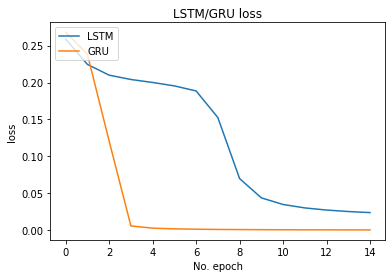

In [10]:
plt.plot(history_LSTM.history['loss'], label='LSTM')
plt.plot(history_GRU.history['loss'], label='GRU')
plt.title('LSTM/GRU loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

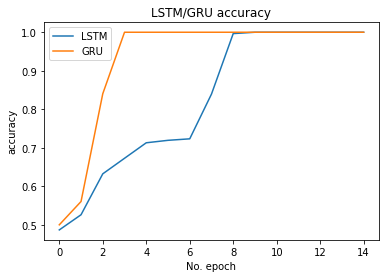

In [11]:
plt.plot(history_LSTM.history['accuracy'], label='LSTM')
plt.plot(history_GRU.history['accuracy'], label='GRU')
plt.title('LSTM/GRU accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

<span style="color:red">__TODO:__</span> Answer the question:

Which part of this task have you been struggling with most of the  time? Describe how you resolved it.

<span style="color:red">__SOLUTION:__</span>
**[The most struggling part is the input and output data size not match. Resolved it by checking the online documents. ]**

<span style="color:red">__TODO:__</span> Answer the question:

Which loss function did you use? Why?

<span style="color:red">__SOLUTION:__</span>

**[I used the MSE i.e. L2 norm loss function. This selection has its reason for it being a more universally used and fundamental function to use. But cross entropy could also be a good choice. ]**

## Part 3 :  Build your own LSTMCell
In this part, you need to build your own LSTM cell to achieve the LSTM functionality (including different types of gates that constitute the cell).

You should refer to the materials on how the LSTM cell works  - with its cell states, activation functions and kernels. 
<br>Please see the course slides or the website https://colah.github.io/posts/2015-08-Understanding-LSTMs/.

<span style="color:red">TODO:</span> 
1. Complete the function **LSTM_step** in utils/xnor/LSTM_step.py;
2. Verify the function by running the provided code.
3. Use the same way (as described above) to build the model and to train it.


In [12]:
from utils.xnor.LSTM_step import LSTM_step

cell_inputs = np.ones((1,1))
cell_states = [0.2*np.ones((1,64)), np.zeros((1,64))]
kernel = 0.1*np.ones((1,256))
recurrent_kernel = 0.1*np.ones((64,256))
bias = np.zeros(256)

h , [h,c] = LSTM_step(cell_inputs, cell_states, kernel, recurrent_kernel, bias)
print('Simple verification:')
print('Is h correct?', np.isclose(h.numpy()[0][0],0.48484358))
print('Is c correct?', np.isclose(c.numpy()[0][0],0.70387213))

Simple verification:
Is h correct? True
Is c correct? True


In [13]:
in_data, out_data = create_xnor_dataset(1000)# create a dataset with a batch size of 1000

In [14]:
###################################################
# TODO: build a model with LSTM cell and train it.#
#                                                 #
###################################################

model = tf.keras.Sequential()
model.add(layers.LSTM(1, input_shape=(8, 1), return_sequences=True))
model.summary()
model.compile(loss=tf.keras.losses.MSE,
              optimizer=tf.keras.optimizers.Adam(lr = 0.01),
              metrics=['accuracy'])
history = model.fit(in_data, out_data, batch_size=8, epochs=15)



###################################################
# END TODO                                        #
###################################################

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 1)              12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
125/125 [==============================] - 1s 2ms/step - loss: 0.3469 - accuracy: 0.4932
Epoch 2/15
125/125 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.4809
Epoch 3/15
125/125 [==============================] - 0s 2ms/step - loss: 0.2413 - accuracy: 0.4686
Epoch 4/15
125/125 [==============================] - 0s 2ms/step - loss: 0.2340 - accuracy: 0.5627
Epoch 5/15
125/125 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.5706
Epoch 6/15
125/125 [==============================] - 0s 2ms/step - loss: 0.2101 - accuracy: 0.6743
Epoch 7/15
125/125 [==============================] 

#### Hint for building a model with LSTM cell
```
model = tf.keras.Sequential()
model.add(# insert layer 1)
model.add(# insert layer 2)
model.add(# insert more layers)
model.add(# insert output layer)

model.summary()
model.compile(loss=#choose your loss function,
              optimizer=#choose your optimizer with learning rate,
              metrics=['accuracy'])
history = model.fit(in_data, out_data, batch_size=64, epochs=15)
```

### Visualize loss and accuracy

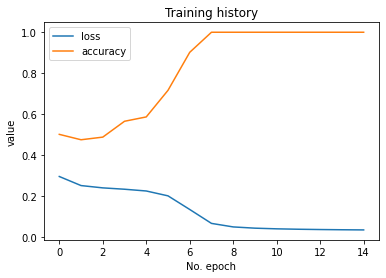

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Training history')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()